# Object Detection Demo

## Demo Overview

In this demonstration we will train a YOLO (You Only Look Once) object detection model to detect the location of turtles and people in images. The scales on the face of sea turtles are unique and can be used to identify individual turtles. If the model detects that a sea turtle is present in an image and generates a bounding box around it, the box can be used to crop out the unnecessary parts of the image.

## Imports Packages, Action Sets and Creates Connection Object

In [1]:
# Import useful packages

import swat
import seaborn as sns
import pandas as pd
import dlpy
from dlpy import mzmodel
from dlpy.model import DataSpec
from dlpy.applications import YoloV2, Tiny_YoloV2
from dlpy.utils import *

/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Establishes connection to the CAS server

conn = swat.CAS('server.demo.sas.com', 30570, 'student', 'Metadata0')

In [3]:
# Changes session timeout

mytime = 60*60*24
conn.session.timeout(time=mytime)

+ Elapsed: 0.000182s, user: 0.000143s, sys: 2.1e-05s, mem: 0.207mb

In [4]:
# Loads the necessary action sets

conn.loadactionset("image")
conn.loadactionset("deeplearn")
conn.loadactionset("sampling")

NOTE: Added action set 'image'.
NOTE: Added action set 'deeplearn'.
NOTE: Added action set 'sampling'.


[actionset]

 'sampling'

+ Elapsed: 0.00277s, sys: 0.00275s, mem: 0.217mb

## Object Detection Table Creation and Exploration

In [ ]:
# # Creates the path for the local annotations and the images

# img_path  = "/path/to/images/and/annotations" 

# # Creates the object detection table

# obj_det_targets = create_object_detection_table(conn,
#                                                 data_path = img_path,
#                                                 local_path = img_path,
#                                                 coord_type = "yolo",
#                                                 image_size = (416, 416),
#                                                 output = "galapagos")

In [5]:
# Creates a caslib pointing to the directory where the dataset is located

conn.table.addcaslib(name = "mycl", path = "/workshop/winsas/VOSI", subdirectories = True)

NOTE: 'mycl' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'mycl'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
0,mycl,PATH,,/workshop/winsas/VOSI/,,1.0,1.0,1.0,0.0,0.0,0.0,Not Specified


In [6]:
# Loads the object detection table 

conn.table.loadtable(path = "galapagos_objdet.sashdat", caslib = "mycl", casout = dict(name = "galapagos", replace = True))

NOTE: Cloud Analytic Services made the file galapagos_objdet.sashdat available as table GALAPAGOS in caslib mycl.


[caslib]

 'mycl'

[tableName]

 'GALAPAGOS'

[casTable]

 CASTable('GALAPAGOS', caslib='mycl')

+ Elapsed: 0.00226s, user: 0.00127s, sys: 0.000794s, mem: 0.749mb

In [7]:
# Displays a sample of the uploaded galapagos dataset

galapagos = conn.CASTable("galapagos")
galapagos.head()

,idjoin,_image_,_Object0_,_Object1_,_Object2_,_Object0_x,_Object1_x,_Object2_x,_Object0_y,_Object1_y,_Object2_y,_Object0_width,_Object1_width,_Object2_width,_Object0_height,_Object1_height,_Object2_height,_nObjects_
0,GAL84_IMG_3419,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,turtle,,,0.718082,NaN,NaN,0.523636,NaN,NaN,0.560374,NaN,NaN,0.846454,NaN,NaN,1.0
1,GAL387_IMG_2059,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,turtle,,,0.562010,NaN,NaN,0.299417,NaN,NaN,0.305159,NaN,NaN,0.313711,NaN,NaN,1.0
2,GAL482_P4090350,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GAL206_P6270243,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,turtle,,,0.512201,NaN,NaN,0.502521,NaN,NaN,0.702318,NaN,NaN,0.912375,NaN,NaN,1.0
4,GAL140_P5261176,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,turtle,,,0.675058,NaN,NaN,0.380926,NaN,NaN,0.646739,NaN,NaN,0.759835,NaN,NaN,1.0


In [8]:
# Displays the detected object types

galapagos["_Object0_"].value_counts()

turtle    1251
person      88
dtype: int64

In [9]:
# Creates an image table of the galapagos dataset and displays a summary of the results

galapagos_img_tbl = dlpy.images.ImageTable.from_table(galapagos)

galapagos_img_tbl.image_summary

ERROR: The column '_id_' does not exist in the table 'IMAGEDATA_QIJBAG'.
ERROR: Failure opening table 'ImageData_QiJBAg': A required column does not exist in the table.
ERROR: The action stopped due to errors.


jpg                   1492.0
minWidth               416.0
maxWidth               416.0
minHeight              416.0
maxHeight              416.0
meanWidth              416.0
meanHeight             416.0
mean1stChannel    127.962563
min1stChannel            0.0
max1stChannel          255.0
mean2ndChannel      125.9192
min2ndChannel            0.0
max2ndChannel          255.0
mean3rdChannel    115.382921
min3rdChannel            0.0
max3rdChannel          255.0
dtype: object

In [10]:
# Stores all of the columns so that this information can be copied freely as new CAS Tables are created

columns = galapagos.columns.to_list()

NOTE: The table _PY_T_BD439312_6A55_4693_AE84_833BE415861D contains encoded images.


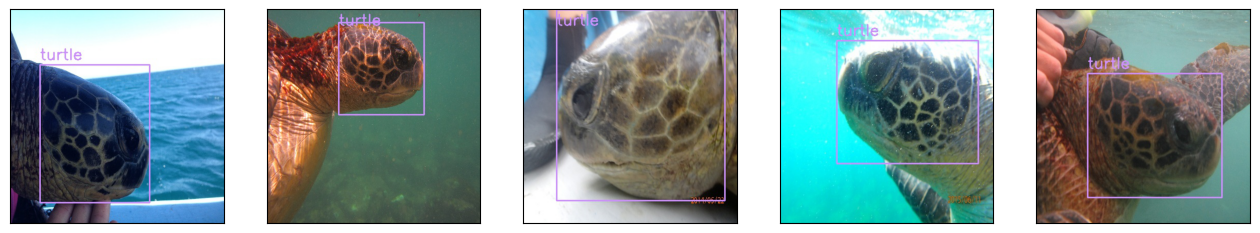

In [11]:
# Displays a sample of the detection objects

display_object_detections(conn,
                          "galapagos",
                          coord_type = "yolo",
                          num_plot = 5,
                          n_col = 5
                          )

## Data Partitioning

In [12]:
# Partitions the data into training and validation

conn.sampling.srs(table=dict(name="galapagos"), samppct=90, seed=42, partind=True,
                  output=dict(casout=dict(name="sampled_data", replace=True), 
                              copyvars="all", partindname="PartInd")
                 )

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=42 for sampling.


[SRSFreq]

 Frequencies
 
    NObs  NSamp
 0  1492   1343

[OutputCasTables]

   casLib          Name Label  Rows  Columns                                 casTable
 0   mycl  sampled_data        1492       19  CASTable('sampled_data', caslib='mycl')

+ Elapsed: 0.317s, user: 0.268s, sys: 0.245s, mem: 194mb

In [13]:
# Partitions the data into training and validation

train = conn.CASTable("sampled_data").query("PartInd = 1 and _nObjects_ > 0")
valid = conn.CASTable("sampled_data").query("PartInd = 0 and _nObjects_ > 0")

In [14]:
# Displays the shapes of the partitions 

display(train.shape)
display(valid.shape)

(1202, 19)

(137, 19)

In [15]:
# Ensures that partitions are correct

display(train["PartInd"].unique())
display(valid["PartInd"].unique())

array([1.])

array([0.])

### Data Augmentation

In [16]:
# Applies image augmentation to the training datasets
    
conn.image.augmentImages(table = train, casout = {"name": "aug_train", "replace": True},  # output CASTable
                         croplist=[{
                                    "usewholeimage": True,
                                    "mutations": {
                                        "sharpen": True,
                                        "lighten": True,
                                        "darken": True,
                                        "horizontalFlip": True,
                                        "colorshifting": True,
                                        "colorjittering": True,
                                        "colorshifting": True,
                                        "colorjittering": True,                                      
                                        }
                                    }
                                   ],
                         copyVars=columns,
                         writeRandomly=True,
                         seed=42
                         )

NOTE: The table SAMPLED_DATA contains encoded images.
NOTE: _image_ is already in the output table.
NOTE: Out of 1202 input images, 4214 images were successfully produced and saved as encoded images to the Cloud Analytic Services table aug_train.


,casLib,Name,Rows,Columns,casTable
0,mycl,aug_train,4214,19,"CASTable('aug_train', caslib='mycl')"


In [17]:
# Creates a CASTable object pointing to the in-memory table

aug_train = conn.CASTable("aug_train")
aug_train.head()

,idjoin,_Object0_,_Object1_,_Object2_,_Object0_x,_Object1_x,_Object2_x,_Object0_y,_Object1_y,_Object2_y,_Object0_width,_Object1_width,_Object2_width,_Object0_height,_Object1_height,_Object2_height,_nObjects_,_image_,_parentId_
0,GAL84_IMG_3419,turtle,,,0.718082,NaN,NaN,0.523636,NaN,NaN,0.560374,NaN,NaN,0.846454,NaN,NaN,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
1,GAL84_IMG_3419,turtle,,,0.718082,NaN,NaN,0.523636,NaN,NaN,0.560374,NaN,NaN,0.846454,NaN,NaN,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
2,GAL84_IMG_3419,turtle,,,0.718082,NaN,NaN,0.523636,NaN,NaN,0.560374,NaN,NaN,0.846454,NaN,NaN,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
3,GAL84_IMG_3419,turtle,,,0.718082,NaN,NaN,0.523636,NaN,NaN,0.560374,NaN,NaN,0.846454,NaN,NaN,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
4,GAL387_IMG_2059,turtle,,,0.562010,NaN,NaN,0.299417,NaN,NaN,0.305159,NaN,NaN,0.313711,NaN,NaN,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0


NOTE: The table _PY_T_F0CFB96C_1A2E_4104_98B7_241939D31066 contains encoded images.


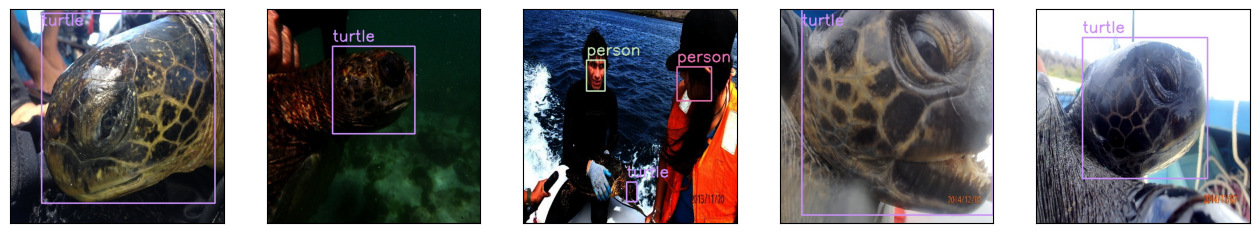

In [18]:
# Displays a sample of the augmented images

display_object_detections(conn, aug_train, coord_type = "yolo",num_plot = 5, n_col = 5)

In [19]:
# Appends the augmented data to the training dataset

conn.deeplearn.dljoin(table = train, annotatedtable = aug_train, jointype = "append",
                      casout = dict(name = "merged_train", replace = True))

# Shuffles the dataset

conn.table.shuffle(table=dict(name = "merged_train"), casout = dict(name = "merged_train", replace = True))

# Creates a CASTable object pointing to the in-memory table

merged_train = conn.CASTable("merged_train")
print("The merged_train dataset contains", str(merged_train.shape[0]), "images.")

The merged_train dataset contains 5416 images.


In [ ]:
# # Alternate way of applying augmentations, image actionset has more options but this way is easier

# aug_train_img_tbl = dlpy.images.ImageTable.from_table(aug_train)
# aug_train_img_tbl.random_mutations(sharpen = True, lighten = True, darken = True, horizontal_flip = True, color_shift = True, color_jitter = True, color_shift = True)

## Anchor Boxes

In [20]:
# Generates the anchors that will be used for the TinyYOLOv2 model using only the training data set

anchors = get_anchors(conn, data = merged_train, coord_type = "yolo", n_anchors = 5)

## Optimization Settings

In [21]:
# Specifies the optimization algorithm details 

optimizer = dict(miniBatchSize=8,
                 logLevel=2,
                 maxEpochs=5,
                 totalBudget=200,
                 regL1=dict(lowerBound=0, upperBound=0.01, logScale=True),
                 regL2=dict(lowerBound=0.0001, upperBound=0.01, logScale=True),
                 algorithm=dict(method="ADAM", 
                                clipgradmax=100,
                                clipgradmin=-100,
                                learningRatePolicy="POLY",
                                learningRate=dict(lowerBound=0.000001, upperBound=0.0001, logScale=True),
                                beta1=dict(lowerBound=0.8, upperBound=0.999),
                                beta2=dict(lowerBound=0.8, upperBound=0.999),
                                ),
                 stagnation=3,  # early stopping
                 threshold=1e-6,
                 ignoreTrainingError=True,
                 dropout=dict(lowerBound=0.0, upperBound=0.20),
                 dropoutType="INVERTED",
                 )

## YOLOv2 Model Definition

In [22]:
# Defines the YOLO model object

yolo = YoloV2(conn, n_classes = 2, anchors = anchors, n_channels = 3, model_table = "galapagos", 
              iou_threshold=0.2, detection_threshold = 0.35, class_scale = 1, coord_scale = 1, prediction_not_a_object_scale = 0.5)

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer add

In [23]:
# Displays the model architecture, along with layer names, types, and input/output shapes

yolo.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,"(416, 416, 3)","(0, 0)",0
1,1,Convo.1,convo,"(3, 3)","(1, 1)",Identity,"(416, 416, 32)","(864, 0)",149520384
2,2,B.N.1,batchnorm,,,Leaky,"(416, 416, 32)","(0, 64)",0
3,3,Pool1,pool,"(2, 2)","(2, 2)",Max,"(208, 208, 32)","(0, 0)",0
4,4,Convo.2,convo,"(3, 3)","(1, 1)",Identity,"(208, 208, 64)","(18432, 0)",797442048
5,5,B.N.2,batchnorm,,,Leaky,"(208, 208, 64)","(0, 128)",0
6,6,Pool2,pool,"(2, 2)","(2, 2)",Max,"(104, 104, 64)","(0, 0)",0
7,7,Convo.3,convo,"(3, 3)","(1, 1)",Identity,"(104, 104, 128)","(73728, 0)",797442048
8,8,B.N.3,batchnorm,,,Leaky,"(104, 104, 128)","(0, 256)",0
9,9,Convo.4,convo,"(1, 1)","(1, 1)",Identity,"(104, 104, 64)","(8192, 0)",88604672


## Pre-Trained DarkNet Weights

Deep Learning model weights can be downloaded from the <a href = "https://support.sas.com/documentation/prod-p/vdmml/zip/index.html">SAS Documentation</a> for a variety of popular deep learning models.

In [24]:
# Loads table containing pre-trained weights

conn.table.loadtable(path = "darknet_weights.sashdat", caslib = "mycl", casout = dict(name = "darknet", replace = True))

NOTE: Cloud Analytic Services made the file darknet_weights.sashdat available as table DARKNET in caslib mycl.


[caslib]

 'mycl'

[tableName]

 'DARKNET'

[casTable]

 CASTable('DARKNET', caslib='mycl')

+ Elapsed: 0.00384s, user: 0.00359s, mem: 0.808mb

In [25]:
# Attaches the weights to the yolo model object

yolo.set_weights("darknet")

NOTE: Model weights attached successfully!


## YOLOv2 Training

In [26]:
# Creates a list of the model targets

obj_det_targets = ["_nObjects_", "_Object0_", "_Object0_x", "_Object0_y", "_Object0_width", "_Object0_height",
                   "_Object1_", "_Object1_x", "_Object1_y", "_Object1_width", "_Object1_height",
                   "_Object2_", "_Object2_x", "_Object2_y", "_Object2_width", "_Object2_height"]

In [27]:
# Specifies the necessary model input information using the dataspecs option

data_specs = [DataSpec(type_='IMAGE', layer = 'Input1', data = "_image_"),
              DataSpec(type_='OBJECTDETECTION', layer = 'Detection1', data = obj_det_targets)]

In [30]:
# # Trains and tunes the YOLOv2 model with darknet as weights as the starting point

# yolo.tune(data = train, validtable = valid, dataspecs = data_specs, 
#           optimizer = optimizer, gpu = 1,
#           initWeights = yolo.model_weights,
#           modelWeights = dict(name = "yolo_weights", replace = True),
#           seed = 42)

NOTE: Using controller.sas-cas-server-default.edu.svc.cluster.local: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 19853216.
NOTE:  Loading weights cost       0.08 (s).
NOTE:  Initializing each layer cost       4.33 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The maximum mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 256.
NOTE: Evaluating 10 hyperparameter configurations.
NOTE: Tuning learningRate with lower bound   1E-6 and upper bound 0.0001 using logarithmic scale.
NOTE: Tuning regL1 with lower bound      0 and upper bound   0.01 using logarithmic scale.
NOTE: Tuning regL2 with lower bound 0.0001 and upper bound   0.01 using logarithmic scale.
NOTE: Tuning dropOut with lower bound      0 and upper bound    0.2
NOTE: Tuning beta1 with lower bound    0.8 and upper bound  0.999
NOTE: Tuning beta2 with lower bound   

,Descr,Value
0,Model Name,galapagos
1,Model Type,Convolutional Neural Network
2,Number of Layers,44
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,18
9,Number of Detection Layers,1


In [ ]:
# # Saves the model table, weights, and weight attributes

# yolo.save_to_table("/workshop/winsas/VOSI")

In [31]:
# Loads model weights and their attributes onto the model object

yolo.load("/workshop/winsas/VOSI/galapagos.sashdat") 

NOTE: galapagos_weights.sashdat is used as model weights.
NOTE: Model weights attached successfully!
NOTE: galapagos_weights_attr.sashdat is used as weights attribute.
NOTE: Model attributes attached successfully!


## YOLOv2 Scoring

In [29]:
# Check existing model weights

yolo.model_weights

CASTable('deep_learning_model_weights')

In [ ]:
# # Attaches tuned weights

# yolo.set_weights("yolo_weights")

In [32]:
# Generates predictions using the YOLO model 

yolo.predict(valid, gpu = 1)

NOTE: Due to data distribution, miniBatchSize has been limited to 6.
NOTE: Using controller.sas-cas-server-default.edu.svc.cluster.local: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           137
 1  Number of Observations Used           137
 2     Average IoU in Detection      0.801423
 3                   Loss Error       42.7411

[OutputCasTables]

   casLib              Name  Rows  Columns                                     casTable
 0   mycl  Valid_Res_VsvxPQ   137     5074  CASTable('Valid_Res_VsvxPQ', caslib='mycl')

+ Elapsed: 11.2s, user: 4.38s, sys: 1.98s, mem: 2.11e+03mb

## Predictions Table Modification

In [33]:
# Creates an object to reference the prediction table

pred_tbl = yolo.valid_res_tbl
pred_tbl.shape

(137, 5074)

In [34]:
# Displays the columns of the predictions table

pred_tbl.columns

Index(['idjoin', '_image_', 'PartInd', '_nObjects_', '_Object0_',
       '_P_Object0_', '_Object0_x', '_Object0_y', '_Object0_width',
       '_Object0_height',
       ...
       '_Object843_x', '_Object843_y', '_Object843_width', '_Object843_height',
       '_Object844_', '_P_Object844_', '_Object844_x', '_Object844_y',
       '_Object844_width', '_Object844_height'],
      dtype='object', length=5074)

In [35]:
# Stores and subsets the columns so that up to three objects can be identified

pred_cols = pred_tbl.columns.to_list()[:19]

In [36]:
# Makes a copy of the predictions table

conn.table.copytable(table = pred_tbl.name, casout = dict(name = "narrow_pred", replace = True))
conn.table.altertable(name = "narrow_pred", keep = pred_cols)

narrow_pred = conn.CASTable("narrow_pred")
narrow_pred.head()

,idjoin,_image_,PartInd,_nObjects_,_Object0_,_P_Object0_,_Object0_x,_Object0_y,_Object0_width,_Object0_height,_Object1_,_P_Object1_,_Object1_x,_Object1_y,_Object1_width,_Object1_height,_Object2_,_P_Object2_,_Object2_x
0,GAL191_PB061893,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0.0,0.0,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
1,GAL220_PB192507,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0.0,2.0,turtle,0.948384,0.498270,0.512335,0.714267,0.858498,person,0.518866,0.413509,0.058478,0.140802,0.08577,NoObject,NaN,NaN
2,GAL156_P6272196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0.0,0.0,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
3,GAL14_PB180593,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0.0,1.0,turtle,0.821937,0.501532,0.474363,0.659046,0.736002,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
4,GAL57_PC130227,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0.0,1.0,turtle,0.986426,0.571868,0.485186,0.412434,0.382433,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN


In [37]:
# Makes a copy of the validation table

conn.table.copytable(table = valid, casout = dict(name = "narrow_valid", replace = True))
conn.table.altertable(name = "narrow_valid", keep = ["idjoin", "_image_", "nObjects", "Object0", "Object1", "Object2"], 
                      columns = [dict(name = "_nObjects_", rename = "nObjects"),
                                 dict(name = "_Object0_", rename = "Object0"), 
                                 dict(name = "_Object1_", rename = "Object1"), 
                                 dict(name = "_Object2_", rename = "Object2")])

narrow_valid = conn.CASTable("narrow_valid")
narrow_valid.head()

,idjoin,_image_,nObjects,Object0,Object1,Object2
0,GAL191_PB061893,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,
1,GAL220_PB192507,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,
2,GAL156_P6272196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,
3,GAL14_PB180593,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,
4,GAL57_PC130227,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,turtle,person,


In [38]:
# Appends validation data to the predictions table 

conn.deeplearn.dljoin(table = narrow_valid, annotatedtable = narrow_pred, 
                      id = "idjoin",
                      casout = dict(name = "pred_w_labels", replace = True))

,casLib,Name,Rows,Columns,casTable
0,mycl,pred_w_labels,137,23,"CASTable('pred_w_labels', caslib='mycl')"


In [39]:
# Creates a CAS object that points at the new predictions table

preds_final = conn.CASTable("pred_w_labels")
preds_final.head()

,idjoin,_image_,nObjects,Object0,Object1,Object2,PartInd,_nObjects_,_Object0_,_P_Object0_,_Object0_height,_Object1_,_P_Object1_,_Object1_x,_Object1_y,_Object1_width,_Object1_height,_Object2_,_P_Object2_,_Object2_x
0,GAL191_PB061893,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,,0.0,0.0,NoObject,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
1,GAL220_PB192507,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,,0.0,2.0,turtle,0.948384,0.858498,person,0.518866,0.413509,0.058478,0.140802,0.08577,NoObject,NaN,NaN
2,GAL156_P6272196,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,,0.0,0.0,NoObject,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
3,GAL14_PB180593,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1.0,turtle,,,0.0,1.0,turtle,0.821937,0.736002,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
4,GAL57_PC130227,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,turtle,person,,0.0,1.0,turtle,0.986426,0.382433,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN


## YOLOv2 Assessment

In [40]:
# Evaluates the YOLO model

yolo_eval = yolo.evaluate_object_detection(valid, "YOLO")
yolo_eval

Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)
Evaluating class: person (4 detections)
Evaluating class: turtle (116 detections)


[{'IoU Threshold': 0.5,
  'Class Evaluation': [{'class': 'person',
    'precision': array([0.        , 0.        , 0.33333333, 0.5       ]),
    'recall': array([0.        , 0.        , 0.04545455, 0.09090909]),
    'AP': 0.045454545454545456,
    'interpolated precision': array([0.5]),
    'interpolated recall': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'total positives': 22,
    'total TP': 2.0,
    'total FP': 2.0},
   {'class': 'turtle',
    'precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.     

In [41]:
# Explores the evaluations at different IoU thresholds

eval_data = [(i["IoU Threshold"], i["AP"], 
              i["Class Evaluation"][0]["total TP"]/i["Class Evaluation"][0]["total positives"],
              i["Class Evaluation"][1]["total TP"]/i["Class Evaluation"][1]["total positives"]) for i in yolo_eval]
eval_df = pd.DataFrame(data = eval_data, columns = ["IoU", "AP", "Person Recall", "Turtle Recall"])
eval_df.head(10)

,IoU,AP,Person Recall,Turtle Recall
0,0.50,0.431426,0.090909,0.845588
1,0.55,0.419212,0.045455,0.838235
2,0.60,0.415807,0.045455,0.830882
3,0.65,0.415807,0.045455,0.830882
4,0.70,0.362126,0.045455,0.794118
5,0.75,0.335153,0.000000,0.720588
6,0.80,0.235144,0.000000,0.573529
7,0.85,0.156533,0.000000,0.404412
8,0.90,0.061224,0.000000,0.169118
9,0.95,0.045455,0.000000,0.029412


Text(0.5, 1.0, 'AP and Recall for Various IoU Thresholds')

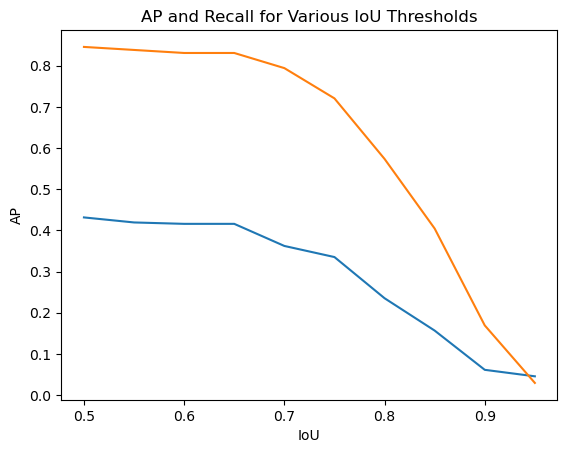

In [42]:
# Plots the AP and Recall vs. IoU Threshold


sns.lineplot(data = eval_df, x = "IoU", y = "AP")
sns.lineplot(data = eval_df, x = "IoU", y = "Turtle Recall").set_title("AP and Recall for Various IoU Thresholds")

NOTE: The table _PY_T_225A80A5_AEF9_4CA7_962D_682EA774F2BD contains encoded images.


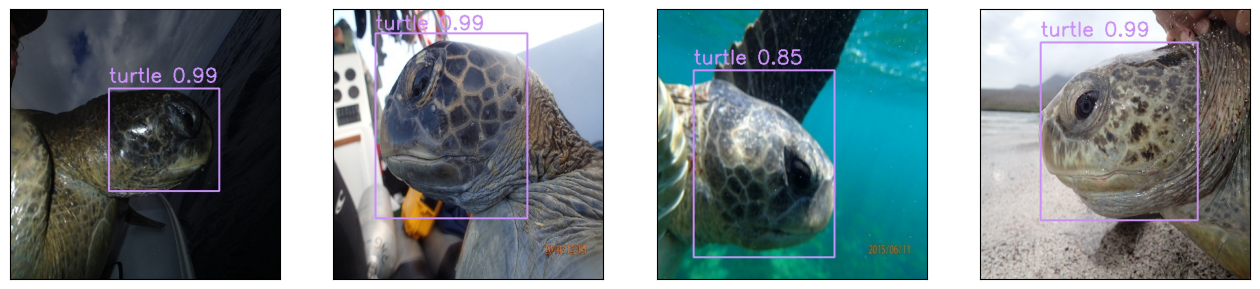

In [43]:
# Displays a sample of the predictions

display_object_detections(conn, pred_tbl, coord_type = "yolo", num_plot = 5, n_col = 5)

In [44]:
# Displays the number of matches in the predictions and validation datasets

matches = preds_final.query("nObjects = _nObjects_")
print("There are", str(matches.shape[0]), "correctly assessed images out of", str(pred_tbl.shape[0]),"validation images.")

There are 106 correctly assessed images out of 137 validation images.


In [45]:
# Displays the number of mismatches in the predictions and validation datasets

mismatches = preds_final.query("Object0 ^= _Object0_ and _nObjects_ > 0")
print("There are", str(mismatches.shape[0]), "mismatches between the first predicted objects.")

There are 4 mismatches between the first predicted objects.


In [46]:
# Displays a sample of some of the mismatches

mismatches.head(10)

,idjoin,_image_,nObjects,Object0,Object1,Object2,PartInd,_nObjects_,_Object0_,_P_Object0_,_Object0_height,_Object1_,_P_Object1_,_Object1_x,_Object1_y,_Object1_width,_Object1_height,_Object2_,_P_Object2_,_Object2_x
0,GAL53_PC072148,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,turtle,person,,0.0,2.0,person,0.422920,0.209331,turtle,0.617615,0.343317,0.66188,0.549841,0.603229,NoObject,NaN,NaN
1,GAL230_PB212993,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,person,turtle,,0.0,1.0,turtle,0.860870,0.665138,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
2,GAL11_PB150530,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,person,person,,0.0,1.0,turtle,0.659760,0.645205,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN
3,GAL474_P4090122,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,person,turtle,,0.0,1.0,turtle,0.924299,0.448663,NoObject,NaN,NaN,NaN,NaN,NaN,NoObject,NaN,NaN


NOTE: The table _T_AJHNI2L5_XHJS3J3E_6V6H7WW4BG contains encoded images.


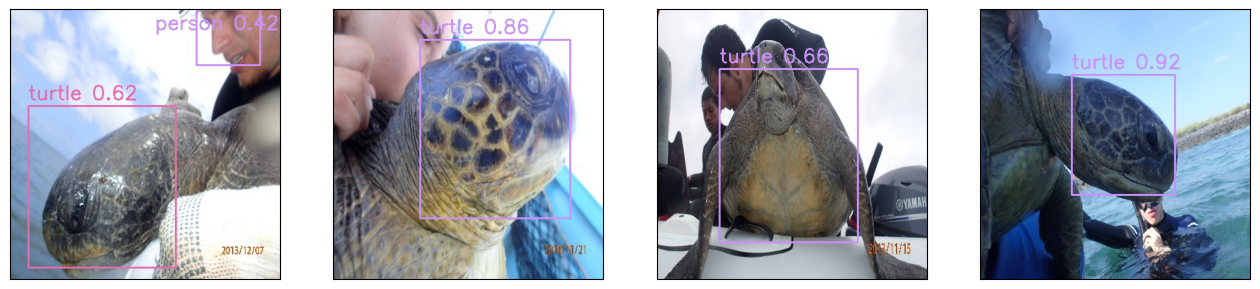

In [47]:
# Displays some of the mismatches 

display_object_detections(conn, mismatches, coord_type = "yolo", n_col = 5, num_plot = 15)

### Saving Model

In [ ]:
# # Model can be saved as an astore file 
# # Requires client-side path

# yolo.save_to_astore("D:\\galapagos\\yolo_model")

In [ ]:
# # Saving model as table
# # Requires server-side path and also stores weights and attributes

# yolo.save_to_table("/workshop/winsas/VOSI")

In [48]:
# Ends the session

conn.session.endsession()

+ Elapsed: 0.000214s, user: 0.000178s, sys: 2.5e-05s, mem: 0.208mb